## Dissertation Project - News Summary Dissertation [100 marks]

### Motivation 

> 1. Provide tools for anyone needing to speed up their research process
> 2. Providing ways for user to quickly determine whether a piece of research is beneficial for their specific search terms




### Imports

In [34]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import random
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import math

import json

DATASET = "./Dataset/"

Detect which device (CPU/GPU) to use.

In [35]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) 
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Overview

Summarisation model
> 1. Dataset preprocessing
> 2. Dataloader
> 3. RNN model definition
> 4. Model training
> 5. Model prediction evaluation
> 6. Dataset Exploration
> 7. Dataset modification/Data Augmentation
> 8. Model improvement
> 9. Model finalisation and evaluation

Paper querying
> 1. Attention on query (Return usefulness percentage
> 2. Evaluate performance


# Data preprocessing

In [3]:
# # Comment this block if dataset is reorganised
# DATA_DIR = "SSN/papers.SSN.jsonl"
# dataset_path = DATASET+DATA_DIR
# with open(dataset_path) as f:
#     lines = f.read().splitlines()
# df_inter = pd.DataFrame(lines)
# df_inter.columns = ['json_element']
# df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))
# df_final.to_json("./Dataset/SSN/SSN_Dataset.json")
# df_final

0         [introduction, tree boosting in a nutshell, re...
1         [introduction, previous work, our approach, su...
2         [introduction, modulation instability of becs ...
3         [introduction, preliminaries, polynomials and ...
4         [introduction, a comment on the large nn and n...
                                ...                        
140794    [introduction, quantum information theory prel...
140795    [introduction, statement of results, an obstru...
140796    [introduction, msugra, more general models, co...
140797    [introduction, pca by determinant optimisation...
140798    [introduction, turbulent convective flux of me...
Name: section_names, Length: 140799, dtype: object

In [4]:
# for i,summary in df_final.iterrows():
#     temp = summary["abstract"]
#     print(type(summary["abstract"]))
#     break

<class 'list'>


In [47]:
# #Comment this block if dataset is shortened
# DATA_DIR = "SSN/SSN_Dataset.json"
# dataset_path = DATASET+DATA_DIR
# df = pd.read_json(dataset_path)
# df

Function to return index for conclusion section

In [112]:
# def trim_index(row):
#     return [row.index(x)+1 for x in row if x.startswith('conclusion') or x.startswith("summar")]

In [113]:
# def trim_text(text, index):
#     return text[0:index]

In [114]:
# # Comment this block if dataset is shortened
# # Trim text after conclusion
# indexes = []
# for i, row in df.iterrows():
#     section = row["section_names"]
#     #print(section)
#     index = trim_index(section)
#     #print(index)
#     if not index:
#         indexes.append(i)
#     # if section can be filtered
#     else:
#         index = index[0]
#         abstract = row["abstract"]
#         text = row["text"]
#         section = row["section_names"]
#         df.at[i, "section_names"] = trim_text(section, index)
#         df.at[i, "abstract"] = trim_text(abstract, index)
#         df.at[i, "text"] = trim_text(text, index)
# # dropping rows in dataframe that can't easily filter out reference section
# print(len(indexes))
# df.drop(indexes, inplace=True)
# df.to_json("./Dataset/SSN/SSN_Dataset_Short.json")

49413


35% of paper will be removed from the dataset due to it not having conclusion(s) and summary(ies) in their section titles, making it difficult to filter out the reference and appendix text

In [136]:
DATA_DIR = "SSN/SSN_Dataset_Short.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
df.reset_index(drop=True, inplace=True)
df

,paper_id,title,abstract,section_names,domain,text
0,4650265,XGBoost: A Scalable Tree Boosting System,[tree boosting is a highly effective and widel...,"[introduction, tree boosting in a nutshell, re...",[],[[machine learning and data - driven approache...
1,9195903,Robust Face Alignment Using a Mixture of Invar...,"[face alignment , which is the task of finding...","[introduction, previous work, our approach, su...",[Computer science],[[face alignment refers to finding the pixel l...
2,119332442,Modulation instability associated nonlinear dy...,[we study pattern - forming nonlinear dynamics...,"[introduction, modulation instability of becs ...",[Physics],[[modulation instability ( mi ) is one of the ...
3,119269876,Light Dilaton at Fixed Points and Ultra Light ...,[we investigate the infrared dynamics of a non...,"[introduction, a comment on the large nn and n...",[Physics],[[understanding strong dynamics constitutes a ...
4,59413881,Decoder-tailored Polar Code Design Using the G...,[we propose a new framework for constructing p...,"[introduction, polar codes, polar code constru...","[Computer science, Mathematics]",[[polar codes are the first family of codes ...
...,...,...,...,...,...,...
91381,1520660,Dirichlet Process Mixtures of Generalized Line...,[we propose dirichlet process mixtures of gene...,"[introduction, related work, mathematical back...","[Mathematics, Computer science]","[[in this paper , we examine the general regre..."
91382,118501110,Minimal Matter at the Large Hadron Collider,"[we classify all possible new u(1 ) x su(2 ), ...","[introduction, new matter and its production, ...",[Physics],[[the higgs mass hierarchy puzzle suggests new...
91383,16180248,On simulations of the classical harmonic oscil...,[we show that any second order linear ordinary...,"[introduction, simplest discretizations of the...","[Physics, Mathematics]",[[the motivation for writing this paper is an ...
91384,15296646,Direct Detection of Neutralino Dark Matter and...,[we compare predictions for the spin - indepen...,"[introduction, msugra, more general models, co...",[Physics],[[the minimal supersymmetric standard model ( ...


In [137]:
summary_df = df[["abstract", "text"]]
summary_df

,abstract,text
0,[tree boosting is a highly effective and widel...,[[machine learning and data - driven approache...
1,"[face alignment , which is the task of finding...",[[face alignment refers to finding the pixel l...
2,[we study pattern - forming nonlinear dynamics...,[[modulation instability ( mi ) is one of the ...
3,[we investigate the infrared dynamics of a non...,[[understanding strong dynamics constitutes a ...
4,[we propose a new framework for constructing p...,[[polar codes are the first family of codes ...
...,...,...
91381,[we propose dirichlet process mixtures of gene...,"[[in this paper , we examine the general regre..."
91382,"[we classify all possible new u(1 ) x su(2 ), ...",[[the higgs mass hierarchy puzzle suggests new...
91383,[we show that any second order linear ordinary...,[[the motivation for writing this paper is an ...
91384,[we compare predictions for the spin - indepen...,[[the minimal supersymmetric standard model ( ...


Check if any columns contain empty values

In [138]:
# summary_df.isnull().any()

\'hi\' \ is used for space <br>
random space, which is used for reference [15] quote box <br>
sec ref is hyperlink to a section <br>
fig ref is hyperlink to a figure <br>
inlineform <br>
displayform are both symbols, both contains numbers in string <br>
remove all forms and remove all symbols but keep numbers <br>

In [139]:
def contain_let(string):
    return any(char.isalpha() for char in string)

In [140]:
def contain_num(string):
    return any(char.isdigit() for char in string)

In [141]:
def cleanLine(line):
    alphabet = list(string.ascii_lowercase)
    number = list(map(str, range(10)))
    symbols = ["'", "’"]
    valid_char = alphabet + number + symbols
    stop_words = list(ENGLISH_STOP_WORDS)
    
    clean_line = line.lower()
    clean_line = clean_line.strip()
    
    # fix apostrophes in line by removing apostrophe with no following alphabet character
    clean_line = clean_line.replace("' ", " ")
    if clean_line and clean_line[-1] == "'":
        clean_line = clean_line[0:len(clean_line)-1]
    # fix apostrophes in line by removing space before single quote
    clean_line = clean_line.replace(" '", "'")
    #remove punctuation
    # replace all non alphabet character with space
    difference = list(set(clean_line).symmetric_difference(valid_char))

    for dif in difference:
        clean_line = clean_line.replace(dif, " ")
    
    # clean line = clean line remove forms
    words = clean_line.split()

    #  remove forms
    words = [x.replace(x, "") if contain_let(x) and contain_num(x) else x for x in words]
    # remove empty strings
    words = filter(None, words)

    # stop words from sklearn, remove stop words
    words = [x for x in words if not x in stop_words]

    # combine the items into 1 string
    clean_line = ' '.join(words)
    return clean_line

In [142]:
def concatParagraph(paragraph):
    clean_paragraph = ""
    for line in paragraph:
        lines = cleanLine(line)
        clean_paragraph += cleanLine(lines) + " "
        #print(clean_paragraph)
        
    return(clean_paragraph.strip())

In [143]:
def concatPaper(paper):
    clean_paper = ""
    for paragraph in paper:
        para = concatParagraph(paragraph)
        #print(para)
        clean_paper += concatParagraph(paragraph) + " "
    return(clean_paper.strip())

In [144]:
for i, row in tqdm(summary_df.iterrows(), total=df.shape[0]):
    abstract = row["abstract"]
    paper = row["text"]
    
    summary_df.at[i, "abstract"] = concatParagraph(abstract)
    summary_df.at[i, "text"] = concatPaper(paper)

  0%|          | 0/91386 [00:00<?, ?it/s]

In [145]:
summary_df.to_json("./Dataset/SSN/SSN_Dataset_Short_Clean.json")
summary_df

,abstract,text
0,tree boosting highly effective widely used mac...,machine learning data driven approaches import...
1,face alignment task finding locations set faci...,face alignment refers finding pixel locations ...
2,study pattern forming nonlinear dynamics start...,modulation instability mi fundamental process ...
3,investigate infrared dynamics nonsupersymmetri...,understanding strong dynamics constitutes cont...
4,propose new framework constructing polar codes...,polar codes family codes proven capacity achie...
...,...,...
91381,propose dirichlet process mixtures generalized...,paper examine general regression problem gener...
91382,classify possible new u 1 x su 2 x su 3 multip...,higgs mass hierarchy puzzle suggests new physi...
91383,second order linear ordinary diffrential equat...,motivation writing paper observation small app...
91384,compare predictions spin independent contribut...,minimal supersymmetric standard model mssm bes...


In [146]:
DATA_DIR = "SSN/SSN_Dataset_Short_Clean.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
df

,abstract,text
0,tree boosting highly effective widely used mac...,machine learning data driven approaches import...
1,face alignment task finding locations set faci...,face alignment refers finding pixel locations ...
2,study pattern forming nonlinear dynamics start...,modulation instability mi fundamental process ...
3,investigate infrared dynamics nonsupersymmetri...,understanding strong dynamics constitutes cont...
4,propose new framework constructing polar codes...,polar codes family codes proven capacity achie...
...,...,...
91381,propose dirichlet process mixtures generalized...,paper examine general regression problem gener...
91382,classify possible new u 1 x su 2 x su 3 multip...,higgs mass hierarchy puzzle suggests new physi...
91383,second order linear ordinary diffrential equat...,motivation writing paper observation small app...
91384,compare predictions spin independent contribut...,minimal supersymmetric standard model mssm bes...


In [147]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<start>': 0, '<end>': 1, '<pad>':2, '<unk>':3}
        self.idx2word = {0: '<start>', 1: '<end>', 2: '<pad>', 3: '<unk>'}
        self.idx = 4

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    ## added function for utility
    def get_word(self,index):
        # this returns the word when given an index
        return self.idx2word[index]

    def __len__(self):
        return len(self.word2idx)


In [148]:
def build_vocab(data):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    MIN_FREQUENCY = 2
    word_mapping = Counter()

    # for index in df.index:
    for text in tqdm(data):
        for word in text.split():
            #print(word)
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)

    return vocab


In [149]:
abstract_vocab = build_vocab(df["abstract"])

  0%|          | 0/91386 [00:00<?, ?it/s]

In [150]:
text_vocab = build_vocab(df["text"])

  0%|          | 0/91386 [00:00<?, ?it/s]

In [151]:
def tokenise(vocab, text, max_len):
    word_ids = []
    for word in text.split():
        word_ids.append(vocab(word))
    word_ids.append(vocab("<end>"))
#     while len(word_ids) < max_len:
#             word_ids.append(vocab("<pad>"))
    return word_ids

In [152]:
ABSTRACT_MAX = 100
TEXT_MAX = 5000

In [153]:
class SSNDataset(Dataset):
    def __init__(self, df, a_vocab, t_vocab):

        self.df = df
        self.a_vocab = a_vocab
        self.t_vocab = t_vocab
        self.abstract_max_len = ABSTRACT_MAX
        self.text_max_len = TEXT_MAX

    def __getitem__(self, index):
        # return word_id
        abstract = self.df.iloc[index]["abstract"]
        text = self.df.iloc[index]["text"]
        
        a_word_ids = tokenise(self.a_vocab, abstract, self.abstract_max_len)
        t_word_ids = tokenise(self.t_vocab, text, self.text_max_len)

        a_length = len(a_word_ids)
        t_length = len(t_word_ids)
    
        return torch.tensor(a_word_ids), torch.tensor(t_word_ids)# torch.tensor(t_length)# torch.tensor(t_length)

    def __len__(self):
        return len(self.df)


In [154]:
def text_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple of 2 word ids
        - abstract id
        - text id
    Returns:
        abstract list ids
        text list ids
    """
    
    abstracts, texts = zip(*data)
#     abstracts = [ torch.Tensor(abstract).to(device) for abstract in abstracts ]
# if batch size is 1 then use [0]
    abstracts = torch.stack(abstracts, 0)
    #abstracts = abstracts.unsqueeze(0)
#     abstracts = torch.nn.utils.rnn.pad_sequence(abstracts)
    texts = torch.stack(texts, 0)
    #texts = texts.unsqueeze(0)

    return abstracts, texts


# Dataloader

Split dataset

In [155]:
train_data, test_data = train_test_split(df, random_state=seed, train_size = 0.7)
train_data, valid_data = train_test_split(train_data, random_state=seed, train_size=0.8)

In [156]:
train_set = SSNDataset(train_data, abstract_vocab, text_vocab)
valid_set = SSNDataset(valid_data, abstract_vocab, text_vocab)
test_set = SSNDataset(test_data, abstract_vocab, text_vocab)

In [157]:
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, collate_fn=text_collate_fn) # num_worker can't be 2+ as the time it 
                                                                 # takes to build iter is much longer

In [158]:
valid_loader = DataLoader(valid_set, batch_size=1, shuffle=True, collate_fn=text_collate_fn)

In [168]:
all_set = SSNDataset(df, abstract_vocab, text_vocab)
all_loader = DataLoader(all_set, batch_size=1, shuffle=True, collate_fn=text_collate_fn)
abstracts = []
texts = []
for i, (abstract, text) in enumerate(all_loader):
    a_size = list(abstract.size())[1]

    t_size = list(text.size())[1]
    abstracts.append(a_size)
    texts.append(t_size)
numbers = list(range(len(all_loader)))

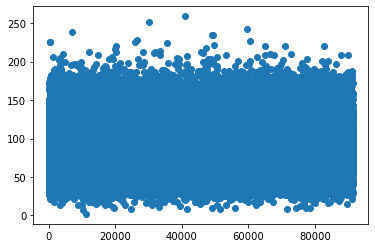

In [173]:
plt.scatter(numbers, abstracts)
plt.show()

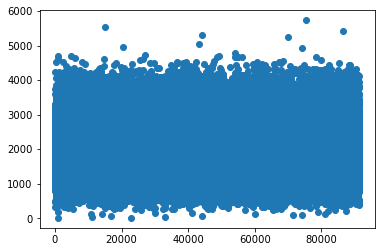

In [174]:
plt.scatter(numbers, texts)
plt.show()

In [167]:
from statistics import mean
print("max length for abstract: ",max(abstracts))
print("max length for text: ",max(texts))
print("min length for abstract: ",min(abstracts))
print("min length for text: ",min(texts))
print("average length for abstract: ",math.floor(mean(abstracts)))
print("average length for text: ",math.floor(mean(texts)))

max length for abstract:  259
max length for text:  5732
min length for abstract:  2
min length for text:  13
average length for abstract:  85
average length for text:  2029


In [220]:
print("50 percentile: ", np.percentile(texts, 0.08))
print("90 percentile: ", np.percentile(abstracts, 0.08))

50 percentile:  371.108
90 percentile:  20.0


# RNN Model definition

In [52]:
class Encoder(nn.Module):
    def __init__(self, voc_size, num_layer, hidden_dim, device):
        super(Encoder, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.num_layer = num_layer
        
        self.embeddings = nn.Embedding(
            num_embeddings=voc_size,
            embedding_dim=hidden_dim
        )
        self.lstm = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layer,
            bidirectional=False,
            batch_first=True
        )

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layer, batch_size, self.hidden_dim, device=device)
#                 torch.zeros(self.num_layer, batch_size, self.hidden_dim, device=device))

    def forward(self, input):
        #start = time.time()

        #print(input.shape)
        lengths = (input != 2).sum(1) # pad index = 2
        batch_size = input.shape[0]
        initial_hidden = self.init_hidden(batch_size)
        embedded = self.embeddings(input)
        #print("lengths: ",lengths.shape)
#         print(lengths)
        print("embedded: ",embedded.shape)
        print("embedded: ",embedded.view(1, 1, -1).shape)
    
#         print("initial_hidden", initial_hidden.shape)
        embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), 
                                                           batch_first=True,enforce_sorted=False)
#         print("embedded: ",embedded[0].shape)
#         print("embedded: ",embedded[1].shape)
        output, hidden = self.lstm(embedded, initial_hidden)
        #print("output: ",output.shape)
        output, lengths = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        lengths = lengths.to(device)
        #end = time.time()
        #print("Encoder Time: ",end - start)
#         print("-----------")
#         print("output: ",output.shape) # [batch, seq_len, hidden_dim]
#         print("hidden: ",hidden.shape) # [layer, batch, hidden_dim]
        return output, hidden, lengths

In [68]:
class Decoder(nn.Module):
    def __init__(self, voc_size, num_layer,hidden_dim):
        super(Decoder, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=voc_size,
            embedding_dim=hidden_dim
        )
        self.attention = Attention(hidden_dim,hidden_dim)
        self.lstm = nn.GRU(
            input_size=2*hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layer,
            bidirectional=False,
            batch_first=True
        )
        self.fc = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=voc_size
        )
        self.logsoftmax = nn.LogSoftmax(dim=1)
    

    def forward(self, input, hidden, context, encoder_outputs, lengths): # also add in encoder outputs 
                                                                # to create context
        #start = time.time()
        embedded = self.embeddings(input) # [batch, 256]
        # hidden = [bathc, seq_len, hidden_dim]
        # print(hidden[0])
        #hidden_permute = hidden.permute(0,1) # [1, 512]
        decoder_input = torch.cat((embedded, context), -1).unsqueeze(1) # [batch, 1, 512]
        decoder_output, hidden = self.lstm(decoder_input, hidden)
        decoder_output = decoder_output.squeeze(1)
        
        # mask to block decoder from knowing future sequences/block padding
        max_len = lengths.max().item()
    
        mask = torch.arange(max_len).expand(len(lengths), max_len) < lengths.unsqueeze(1).cpu()
        mask = mask.to(device)
        attention = self.attention(decoder_output, encoder_outputs, mask).to(device)

        context = attention.unsqueeze(1).bmm(encoder_outputs).squeeze(1)
        #print("context shape: ", context.shape)
        output_context = torch.cat((decoder_output, context), dim=1) # []
        output_context = torch.nn.functional.relu(output_context)
        
        output_context = self.fc(output_context)
        #print(output[0])
        output = self.logsoftmax(output_context)
        #end = time.time()
        #print("Decoder Time: ",end - start)
#         print("decode output: ",output)
#         print("output: ", output.shape)
        # output is [batch, seq_len, hidden_dim]
        # hidden = 2,2,256 [2, batch, hidden_dim]
        return output, hidden, context, attention
    

In [69]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        
        self.attn_hidden_vector = nn.Linear(encoder_hidden_dim + decoder_hidden_dim, decoder_hidden_dim)
        
        self.attn_scoring_fn = nn.Linear(decoder_hidden_dim, decoder_hidden_dim, bias=False)
        
        
    def forward(self, hidden, encoder_outputs, mask):
        
        
    
        # hidden = [num_layer, batch size, decoder hidden dim]
        # encoder_outputs [batch, seq_len, hidden_dim]
        seq_len = encoder_outputs.shape[1] # 10000
        batch_size = encoder_outputs.shape[0]
        
        
        
        #attention_scores = torch.zeros((batch_size, seq_len), device=device)

        hidden = hidden.repeat(encoder_outputs.shape[1],1,1)

        encoder_outputs = encoder_outputs.permute(1,0,2)

        
#         print("attention score: ", attention_scores.shape)
#         print("hidden atten: ",hidden.shape)
#         print("encoder output: ", encoder_outputs.shape)


        attention_scores = torch.einsum('sbd,sbd->bs',hidden, encoder_outputs)
        #print("attention_scores: ",attention_scores.shape)
            
        
        
#         print(attention_scores.shape)
#         print(attention_scores)
#         global attention_scoresg
#         attention_scoresg = attention_scores
            
        attention_scores[~mask] = -float('inf')
        attention_scores = nn.functional.relu(attention_scores)
        #end = time.time()
        #print("Attention Time: ",end - start)
        return nn.functional.softmax(attention_scores, dim=1)


In [70]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, hidden_dim):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.hidden_dim = hidden_dim

    def forward(self, abstract, text):
        #decoder = Decoder(len(abstract_vocab), 512).to(device)
        output, hidden, lengths = self.encoder(text) # [10000, 512] [seq_len, hidden_dim]
        batch_size = output.shape[0]

        # encoder hidden and cell

        decoder_hidden = hidden
        context = torch.zeros(text.shape[0], self.hidden_dim).to(device) # batch, hidden_dim
        decoder_input = torch.LongTensor([0]).repeat(batch_size).to(device)
#         out1 = output[0] # varied
#         out2 = output[1]
#         out3 = output[2]

        #input, hidden, context, encoder_outputs
        # squeeze converts the [[]] 3d tensor to 2D, then detach converts it to 1D and item converts to int
    #     _, initial = decode_output.topk(1)
    #     initial = initial.squeeze().detach().item()
    #     start_input = [initial]
    #     decoded_words = [initial]
        decoded_words = [[]]
        done = [False]
        decoded_loss = torch.Tensor().to(device)
        
        # attentions = []
        # repeat until end token, but should limit to less than text length
        # try keeping the variable length
        # when calculating loss expand either prediction or original to fit the lengthier target's length
        # by filling the rest with token for pad

        for i in range(100):
            decoder_output, decoder_hidden, context, attention = self.decoder(decoder_input, 
                                                                  decoder_hidden, context, output, lengths)
            
            #print(decoder_output)

            # return attention
            # attentions.append(attention)
            # teacher forcing here, basically use ground truth values for input
    #         if random.uniform(0, 1) > 0.5:
            decoded_loss = torch.cat((decoded_loss, decoder_output.unsqueeze(1)), 1)
            _, topi = decoder_output.topk(k=1)
    #         else:
    #             topi = text[i]

            decoder_input = decoder_output.argmax(1)
            #print(decoder_input)

            for j in range(1):
                if decoder_input[j].item() == 1:
                    done[j] = True
                if not done[j]:
                    decoded_words[j].append(decoder_input[j].item())
                else:
                    decoded_words[j].append(2)
            start_input = [decoder_input.item()]
            #do some processing here to convert words into tensor for loss calculation

        for k in range(1):
            sentence=""
            for i in decoded_words[k]:
                sentence+= abstract_vocab.get_word(i) + " "
            print(sentence)
        for i in range(1):
            sentence=""
            for i in abstract[i]:
                sentence+= abstract_vocab.get_word(i.item()) + " "
            print(sentence)
        #print((decoded_loss))
        return decoded_loss

In [74]:
encoder = Encoder(len(text_vocab), num_layer=2, hidden_dim=256, device=device)
encoder = encoder.to(device)
decoder = Decoder(len(abstract_vocab), num_layer=2, hidden_dim=256)
decoder = decoder.to(device)
# abstract, text = next(iter(train_loader))
# abstract = abstract.to(device)
# text = text.to(device)
model = Model(encoder, decoder, 256)
model = model.to(device)
#out1 = model(abstract, text)

# Tasks
~~1 - Complete model definition~~ <br>
~~2 - fix word vocab~~ <br>
~~3 - Define Attention model and combine with Decoder~~ <br>
    ~~1 - Adjust to allow for batch ~~<br>
4 - trace through program to see where it starts to have the same tensor <br>
~~5 - use mask to hide paddings~~ switch on off to see difference<br>
~~6 - Switch from GRU to LSTM~~ swap to see difference<br>
7 - Add training script to train <br>
 

# Model training

In [75]:
def train(train_loader, valid_loader, model):
    criterion = nn.CrossEntropyLoss(ignore_index=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epoch_size = 10
    loss_points = []
    eval_loss_points = []
    best_loss = 10000

    for epoch in range(epoch_size):
        
        model.train()
        loss_avg = []
        for i, (abstract, text) in enumerate(train_loader):
            # send batch data to device
            abstract = abstract.to(device)
            text = text.to(device)

            
            outputs = model(abstract, text).to(device)

            loss = 0
            for i in range(outputs.shape[1]): # max length for abstract
                temp_loss = criterion(outputs[:,i,:], abstract[:,i])
                
                if not torch.isnan(temp_loss):
                    loss += temp_loss
                else:
                    break
                

            # Optimise
            del abstract
            del text
            del outputs
            loss_avg.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            del temp_loss
            del loss
            torch.cuda.empty_cache()
            optimizer.step()
            #print(loss.item())
        current_loss = np.average(loss_avg)
        loss_points.append(current_loss)

        print('Epoch [{}/{}], Loss: {:.4f}'
            .format(epoch+1, 5, current_loss))

        eval_loss_avg = []

        model.eval()
        with torch.no_grad():
            for j, (abstract, text) in enumerate(valid_loader):
                abstract = abstract.to(device)
                text = text.to(device)

                scores = model(abstract, text)
                eval_loss = 0
                for i in range(scores.shape[1]): # max length for abstract
                    temp_loss = criterion(scores[:,i,:], abstract[:,i])
                    if not torch.isnan(temp_loss):
                        eval_loss += temp_loss
                    else:
                        break
                eval_loss_avg.append(eval_loss.item())
                del abstract
                del text
                del scores
                del temp_loss
                del eval_loss
                torch.cuda.empty_cache()

        current_eval_loss = np.average(eval_loss_avg)
        eval_loss_points.append(current_eval_loss)
        if (current_eval_loss < best_loss):
            best_loss = current_eval_loss
            torch.save(model.state_dict(), 'best_decoder.pth')
            print("Best eval loss updated!")

        print('Valid Epoch [{}/{}], Loss: {:.4f}'
            .format(epoch+1, 5, current_eval_loss))
    return loss_points, eval_loss_points
train_loss, eval_loss = train(train_loader, valid_loader, model)

embedded:  torch.Size([1, 5000, 256])
embedded:  torch.Size([1, 1, 1280000])
compared inspired cpu u shell shell shell pathway pathway pathway pathway pathway case case goal goal direct absence arguments arguments arguments validate side arguments arguments simple matter scalability scalability cpu cpu cpu schemes compare shell treatment access access access access access access hence sheftel cpu distributed treatment treatment computer attribute attribute calculations related mode mode compare treatment mode field cpu cpu leptonic detection shell shell shell studied access subsequent access access access access access access hence sheftel distributed single single induced induced cpu accuracy accuracy accuracy lower deviation deviation dynamics stable stable shell shell shell successfully access access access access 
we propose a mathematical model for cholera with treatment through quarantine the model is shown to be both <unk> and <unk> well <unk> in particular we prove that all sol

embedded:  torch.Size([1, 5000, 256])
embedded:  torch.Size([1, 1, 1280000])
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
imitation learning holds the <unk> to address challenging robotic tasks such as autonomous navigation it however requires a human <unk> to <unk> the training process and <unk> correct control <unk> to <unk> without feedback which is always <unk> to error and <unk> to <unk> human <unk> and avoid <unk> <unk> of data in the

<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
we discuss an efficient numerical scheme for the <unk> filtering of <unk> quantum stochastic master equations we show that the <unk> quantum <unk> is robust and may be used for feedback based on <unk> measurements the proposed numerical scheme is <unk> to approximation which can be used to further reduce the computational <unk> associated with <unk> quantum trajectories and may allow real time qu

embedded:  torch.Size([1, 5000, 256])
embedded:  torch.Size([1, 1, 1280000])
the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
we address the problem of <unk> domain image retrieval considering the following practical application given a user <unk> <unk> a clothing image our goal is to <unk> the same or attribute similar clothing items from online shopping <unk> this is a challenging problem due to the large <unk> between online shopping images usually <unk> in <unk> <unk> pose background conditions and user photos <unk> in <unk> conditions to address this problem we propose a dual attribute aware <unk> network darn for retrieval feature lea

embedded:  torch.Size([1, 5000, 256])
embedded:  torch.Size([1, 1, 1280000])
we <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
machine learning is used in a number of <unk> related applications such as biometric user authentication speaker identification <unk> a type of <unk> <unk> attack against machine learning called poisoning attack works by injecting <unk> <unk> data points in the training data so as to <unk> the false positive rate of the cla

KeyboardInterrupt: 

In [37]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss','Valid loss'])

NameError: name 'train_loss' is not defined

# Model Evaluation

In [22]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Dataset Exploration

In [16]:
df

,paper_id,title,abstract,section_names,domain,text
0,4650265,XGBoost: A Scalable Tree Boosting System,['tree boosting is a highly effective and wide...,"['introduction', 'tree boosting in a nutshell'...",[''],[['machine learning and data - driven approach...
1,9195903,Robust Face Alignment Using a Mixture of Invar...,"['face alignment , which is the task of findin...","['introduction', 'previous work', 'our approac...",['Computer science'],[['face alignment refers to finding the pixel ...
2,119332442,Modulation instability associated nonlinear dy...,['we study pattern - forming nonlinear dynamic...,"['introduction', 'modulation instability of be...",['Physics'],[['modulation instability ( mi ) is one of the...
3,13494452,Free evolution on algebras with two states,['the key result in the paper concerns two tra...,"['introduction', 'preliminaries', 'polynomials...",['Mathematics'],[['in a series of papers belinschi and nica in...
4,119269876,Light Dilaton at Fixed Points and Ultra Light ...,['we investigate the infrared dynamics of a no...,"['introduction', 'a comment on the large nn an...",['Physics'],[['understanding strong dynamics constitutes a...
...,...,...,...,...,...,...
140794,12157610,Minimal and Maximal Operator Spaces and Operat...,['we examine k - minimal and k - maximal opera...,"['introduction', 'quantum information theory p...",['Mathematics'],[['a primary goal of this paper is to formally...
140795,14690185,AN OBSTRUCTION TO ASYMPTOTIC SEMISTABILITY AND...,"['in this paper , we consider an obstruction t...","['introduction', 'statement of results', 'an o...",['Mathematics'],[['for a polarized algebraic manifold inlinefo...
140796,15296646,Direct Detection of Neutralino Dark Matter and...,['we compare predictions for the spin - indepe...,"['introduction', 'msugra', 'more general model...",['Physics'],[['the minimal supersymmetric standard model (...
140797,119576690,PCA by Optimisation of Symmetric Functions has...,['principal component analysis ( pca ) finds t...,"['introduction', 'pca by determinant optimisat...",['Mathematics'],"[['let inlineform0 be a data matrix , with row..."


In [20]:
df.iloc[0]["text"]

'[[\'machine learning and data - driven approaches are becoming very important in many areas .\', \'smart spam classifiers protect our email by learning from massive amounts of spam data and user feedback ; advertising systems learn to match the right ads with the right context ; fraud detection systems protect banks from malicious attackers ; anomaly event detection systems help experimental physicists to find events that lead to new physics .\', \'there are two important factors that drive these successful applications : usage of effective ( statistical ) models that capture the complex data dependencies and scalable learning systems that learn the model of interest from large datasets .\', \'among the machine learning methods used in practice , gradient tree boosting   is one technique that shines in many applications .\', \'tree boosting has been shown to give state - of - the - art results on many standard classification benchmarks   .\', \'lambdamart   , a variant of tree boostin

In [58]:
def get_df_lengths(df):
    ratio = []
    for i,row in df.iterrows():
        article = len(row["article"].split())
        highlight = len(row["highlights"].split())
        if (i==137538):
            print(row["article"])
            print("---------------------")
            print(row["highlights"])
        ratio.append(highlight/article)
    return ratio

In [59]:
ratio = get_df_lengths(df)

Downton Abbey's famously grim butler, Mr Bates .
---------------------
And now for the good news . . . Following a particularly grim week, here’s a compendium of some of the world’s most comforting headlines: .
Supermodel Smiles On Catwalk .
Jack Russell Dog Welcomes Stranger .
Child At Funfair ‘Delighted’ By Goldfish .
Katie Price Breasts ‘Roughly Same Size As Last Week’ Say Experts .
Teenager Looks Up From Phone, Greets Parent .
Political Pundits Agree To Stop Discussing Hung Parliament For Next Three Months .
Diner Finishes His Curly Kale .
Pensioner Looks Great In Party Hat .
Celebrity Fails To Compare Life To Roller-coaster .
Pet Hamster Repays Child’s Affection .
‘Cheer Up, It May Never Happen’ — Downton’s Mr Bates Enjoys Belly-laugh .
Style Journalist Fails To Employ The Word ‘Iconic’
Sally Bercow Goes Out On Town, Retains Dignity .
Entire Windfarm Operates According To Plan .
Miley Cyrus Feels A Bit Chilly, Opts For Extra Layer .


In [47]:
ratio

[0.18686868686868688,
 0.09693877551020408,
 0.0853960396039604,
 0.09981167608286252,
 0.11551724137931034,
 0.12574850299401197,
 0.03099730458221024,
 0.08695652173913043,
 0.09688013136288999,
 0.06306306306306306,
 0.09338235294117647,
 0.09428129829984544,
 0.04805914972273567,
 0.14903846153846154,
 0.05941845764854614,
 0.12058212058212059,
 0.03619909502262444,
 0.05114029025570145,
 0.14392059553349876,
 0.09248554913294797,
 0.11290322580645161,
 0.06223175965665236,
 0.025252525252525252,
 0.0670807453416149,
 0.07357357357357357,
 0.059931506849315065,
 0.0497335701598579,
 0.04749512036434613,
 0.22916666666666666,
 0.12189616252821671,
 0.10119840213049268,
 0.04323094425483504,
 0.09049773755656108,
 0.022063208109719738,
 0.10561797752808989,
 0.16293929712460065,
 0.058163265306122446,
 0.11014492753623188,
 0.04020979020979021,
 0.13213213213213212,
 0.1079734219269103,
 0.05200945626477541,
 0.07241379310344828,
 0.07616707616707617,
 0.09510869565217392,
 0.1128472

In [50]:
max(ratio)

19.0

In [51]:
ratio.index(max(ratio))

137538

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


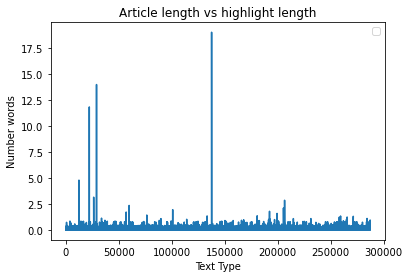

In [48]:
sep = np.arange(len(art_len))

plt.plot(ratio)

plt.xlabel("Text Type")
plt.ylabel("Number words")
plt.title("Article length vs highlight length")
plt.legend()
plt.show()

In [29]:
df.isnull().any()

id            False
article       False
highlights    False
dtype: bool

After exploring, all highlight:article ratio being more than 1.0 means the summary text is producing more text than the original text, this defeats the purpose of the model, therefore all data with a ratio of more than or equal to 1.0 will be omitted.

# Dataset modification/Data Augmentation

In [ ]:
aug_data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

# Model improvement/Retrain

# Model Finalisation and Evaluation